<a href="https://colab.research.google.com/github/LuanPCunha/TCC/blob/main/Treinamento_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloads e imports

In [ ]:
# !pip install tensorflow
# !pip install keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sklearn
import numpy as np
import pandas as pd
from numpy import loadtxt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras import layers
from keras.layers import Dropout, Conv1D, MaxPooling1D, Flatten, Dense, SpatialDropout1D, BatchNormalization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import schedules, Adam, Adadelta, SGD, RMSprop, Adagrad, Adamax, Nadam, Ftrl # Estamos usando só o Nadam
from keras.models import Sequential
from keras.layers.embeddings import Embedding

from keras.callbacks import Callback, ModelCheckpoint, CSVLogger
from sklearn.metrics import roc_auc_score, roc_curve

In [ ]:
def tokenize(tweets_list):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(tweets_list)
    return tokenizer.texts_to_sequences(tweets_list), tokenizer

In [ ]:
def pad(text_tokenized, length=None):
    return pad_sequences(text_tokenized, maxlen=length, padding='post')

In [ ]:
def preprocess(tweets_list, max_text_length):
   
    preprocess_tweets_list, tweets_list_tokenizer = tokenize(tweets_list)

    preprocess_tweets_list = pad(preprocess_tweets_list, length=max_text_length)

    return preprocess_tweets_list, tweets_list_tokenizer

In [ ]:
def logits_to_text(logits, tokenizer):
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

In [ ]:
# Plot de Gráficos

def plot_accuracy(history, miny=None):
  loss, accuracy, val_loss, val_accuracy = list(history.history.keys())
  print(accuracy,val_accuracy,loss,val_loss)
  acc = history.history[accuracy]
  test_acc = history.history[val_accuracy]
  epochs = range(len(acc))
  plt.plot(epochs, acc)
  plt.plot(epochs, test_acc)
  if miny:
    plt.ylim(miny, 1.0)
  plt.legend(['train', 'test'], loc='upper left')
  plt.title('accuracy') 
  plt.xlabel('epoch')
  plt.show()
  
  loss = history.history[loss]
  val_loss = history.history[val_loss]
  epochs = range(len(loss))
  plt.plot(epochs, loss)
  plt.plot(epochs, val_loss)
  if miny:
    plt.ylim(miny, 1.0)
  plt.legend(['train', 'test'], loc='upper left')
  plt.title('loss') 
  plt.xlabel('epoch')
  plt.show()

In [ ]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            self.score = roc_auc_score(self.y_val, y_pred)
            self.false_positive_rate, self.true_positive_rate, _ = roc_curve(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: {:d} - score: {:.6f}".format(epoch+1, self.score))
            
    def print_curve(self):        
        plt.figure()
        lw = 2
        plt.plot(self.false_positive_rate,self.true_positive_rate,color="darkorange",lw=lw,label="ROC curve (area = %0.2f)" % self.score)
        plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Receiver operating characteristic example")
        plt.legend(loc="lower right")
        plt.show()
              

# Carrega base

In [ ]:
# Base1 Com StopWords
PATH_BASE1_JUNTO_COM_DA_LEILA_BALANCEADA = "/content/drive/MyDrive/TCC/dados/processadas/balanceadas/Base1JuntaHateENotHateDaLeila_balanceada.csv"
#MATRIZ_CBOW_300_BASE_1 = loadtxt("/content/drive/MyDrive/TCC/dados/word_embeddings/Matriz_Base1JuntaHateENotHateDaLeila_balanceada_CBOW300.CSV", delimiter=',')

# Base2 Sem StopWords
PATH_BASE2_LEILA_LIMPISSIMA_BALANCEADA = "/content/drive/MyDrive/TCC/dados/processadas/balanceadas/Base2_maior4_menor25_limpissima_balanceada.csv"
#MATRIZ_CBOW_300_BASE_2_LEILA = loadtxt("/content/drive/MyDrive/TCC/dados/word_embeddings/Matriz_Base2_maior4_menor25_limpissima_balanceada_CBOW300.CSV", delimiter=',')

PATH_BASE_1_CLASSIFICADA_BALANCEADA = r"/content/drive/MyDrive/TCC/dados/processadas/balanceadas/Base1_classificada_balanceada.csv" #entrada

PATH_BASE_2_CLASSIFICADA_BALANCEADA = r"/content/drive/MyDrive/TCC/dados/processadas/balanceadas/Base2_classificada_balanceada.csv" #entrada
MATRIZ_CBOW_300_BASE_2 = loadtxt("/content/drive/MyDrive/TCC/dados/word_embeddings/Matriz_Base2_classificada_balanceada_CBOW300.csv", delimiter=',') #saida

# Execução modelo

In [ ]:
tweets = pd.read_csv(PATH_BASE_2_CLASSIFICADA_BALANCEADA, index_col=0)
text_column = tweets['text']
text_column

0        retwet bahia fazer sendo governada pt sei baia...
1        k imagine atitude mental negativa f idiota fec...
2        general heleno é bolsonaro rosna late late lat...
3        alan ser cara pau achar havendo ruptura nesse ...
4        canalhascomunistas caçarão chapa presidencialn...
                               ...                        
10569               af hein amiga mandar outro número mail
10570    egoísmo é grande parte produto sociedade émile...
10571    abençoado novo linda querida obrigada carinho ...
10572                              leva gente amorzinhos d
10573                                   k k ata meia sonsa
Name: text, Length: 10574, dtype: object

In [ ]:
# Pega a média de caracteres dos tweets de toda a base
max_text_length = int(text_column.apply(lambda x: len(str(x).split(' '))).max())
max_text_length

55

In [ ]:
output_label = tweets['label']
input_data, text_tokenizer = preprocess(text_column, None)
    
text_vocab_size = len(text_tokenizer.word_index)
print("Vocabulary size:", text_vocab_size)

Vocabulary size: 19043


In [ ]:
# parametros:
BATCH_SIZE = 64
EPOCHS = 100
VAL_AND_TST_SIZE = 0.2
LEARN_RATE = 0.0001
# ******
BETA_1 = 0.09
BETA_2 = 0.0999
EPSILON = 1e-07
# *****
EMBEDDING_DIMENSION = 300  
MAX_TEXT_SIZE = max_text_length 
VOCAB_SIZE = text_vocab_size

In [ ]:
def optimize (learning_rate, beta_1, beta_2, epsilon):
  
  # return Nadam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon, name="Nadam")
  return RMSprop(learning_rate=learning_rate,rho=0.9,momentum=0.0,epsilon=epsilon,centered=True,name="RMSprop")

In [ ]:
# #optimizer = Adadelta(learning_rate=0.001, rho=0.95, epsilon=1e-07, name="Adadelta") 
# #optimizer = SGD(learning_rate=0.01, momentum=0.0, nesterov=True, name="SGD")
# #optimizer = RMSprop(learning_rate=0.001,rho=0.9,momentum=0.0,epsilon=1e-07,centered=True,name="RMSprop")
# #optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True, name="Adam")
# #optimizer = Adagrad(learning_rate=0.001, initial_accumulator_value=0.1, epsilon=1e-07, name="Adagrad")
# #optimizer = Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax")
# #optimizer = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Nadam") # 96% Embedding Treinado /
# #optimizer = Ftrl(learning_rate=0.001, learning_rate_power=-0.5, initial_accumulator_value=0.1, l1_regularization_strength=0.1, l2_regularization_strength=0.1, l2_shrinkage_regularization_strength=0.001, beta=0.0001, name="Ftrl")

In [ ]:
def create_cnn (vocab_size, embedding_dimen, max_text_size ):

  modelo = keras.Sequential([
    keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIMENSION, input_length=max_text_size),
    # keras.layers.Embedding(input_dim=MATRIZ_CBOW_300_BASE_2.shape[0],
                            # output_dim=MATRIZ_CBOW_300_BASE_2.shape[1],
                            # weights=[MATRIZ_CBOW_300_BASE_2],
                            # embeddings_initializer=keras.initializers.Constant(MATRIZ_CBOW_300_BASE_2),
                            # input_length=max_text_size,
                            # trainable=True),                         
    keras.layers.Conv1D(10,3, activation="relu"),
    keras.layers.Flatten(input_shape=(max_text_size,)),
    keras.layers.Dense(max_text_size, activation='relu'),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1, activation='sigmoid')
    ])
  
  return modelo 
  

In [ ]:
def train_model(input_data, output_label, embedding_dimen, batch_size, epochs, validation_and_test_size):
    
    x_train, x_test, y_train, y_test = train_test_split(input_data, output_label, test_size=validation_and_test_size, random_state=42)

    optimizer = optimize(LEARN_RATE, BETA_1, BETA_2, EPSILON)
    
    model = create_cnn(VOCAB_SIZE, EMBEDDING_DIMENSION, MAX_TEXT_SIZE)
    model.summary()
    # model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), optimizer=optimizer, metrics=['accuracy'])
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=optimizer, metrics=['accuracy'])        
    
    ra_val = RocAucEvaluation(validation_data=(x_test, y_test), interval = 1)
    csv_logger = CSVLogger('log.csv', append=False, separator=';')                                                                                        
    
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split = validation_and_test_size, verbose=2, use_multiprocessing=True,  callbacks = [ra_val,csv_logger])
    scores = model.evaluate(x_test, y_test, verbose=1)
    
    return history, model, x_test, y_test, ra_val


In [ ]:
# plot dos gráficos
history, model1, x_test, y_test, ra_val = train_model(input_data, output_label, EMBEDDING_DIMENSION, BATCH_SIZE, EPOCHS, VAL_AND_TST_SIZE)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 55, 300)           5712900   
                                                                 
 conv1d_11 (Conv1D)          (None, 53, 10)            9010      
                                                                 
 flatten_11 (Flatten)        (None, 530)               0         
                                                                 
 dense_22 (Dense)            (None, 55)                29205     
                                                                 
 dropout_11 (Dropout)        (None, 55)                0         
                                                                 
 dense_23 (Dense)            (None, 1)                 56        
                                                                 
Total params: 5,751,171
Trainable params: 5,751,171
N

In [ ]:
# 67/67 [==============================] - 0s 3ms/step - loss: 0.5627 - accuracy: 0.7059 -> Com Embeddings
# 67/67 [==============================] - 0s 3ms/step - loss: 0.4298 - accuracy: 0.8113 -> Sem Embeddings

accuracy val_accuracy loss val_loss


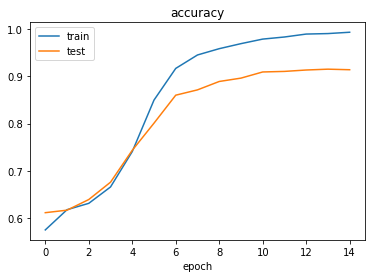

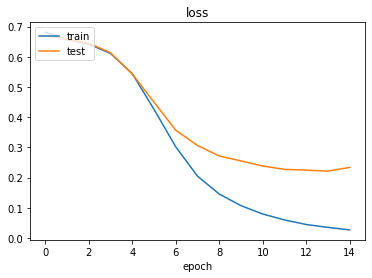

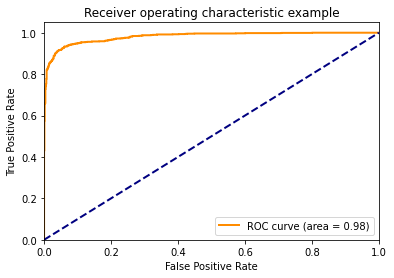

In [ ]:
plot_accuracy(history)
ra_val.print_curve()

In [ ]:
his = pd.read_csv('log.csv',sep=';') 
his.head(55)

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.575292,0.681431,0.611702,0.670293
1,1,0.617999,0.657157,0.617021,0.658044
2,2,0.631447,0.642030,0.639480,0.645447
3,3,0.666026,0.611101,0.676123,0.613437
4,4,0.740801,0.544231,0.743499,0.543318
5,5,0.849564,0.426128,0.800827,0.449593
6,6,0.916507,0.301694,0.859929,0.356896
7,7,0.944880,0.204615,0.871158,0.306187
8,8,0.958179,0.145203,0.888889,0.271328
9,9,0.968819,0.106739,0.895981,0.255009


In [ ]:
y_prob = model1.predict(x_test) 
#y_labelpred = y_prob.argmax(axis=-1)
print(y_prob)
y_labelpred = y_prob.round()

y_labeltrue=y_test

[[1.        ]
 [0.00445946]
 [0.14951415]
 ...
 [0.00628558]
 [0.99999976]
 [0.3786324 ]]


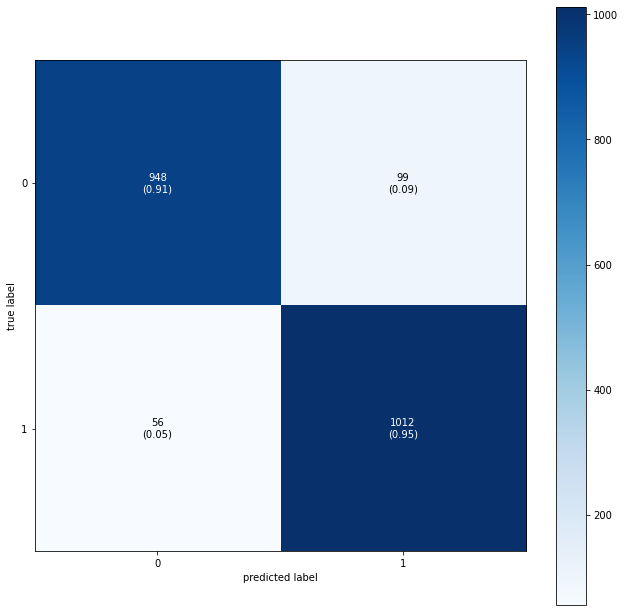

In [ ]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

classes = confusion_matrix(y_labeltrue,y_labelpred)

fig,ax = plot_confusion_matrix(figsize=(11, 11),conf_mat=classes,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=True,
                              )
plt.show()

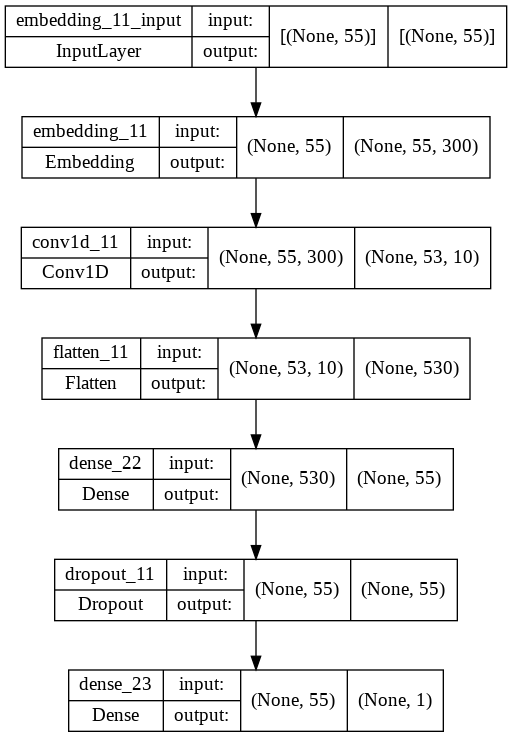

In [ ]:
tf.keras.utils.plot_model(model1, to_file='/meuarquivo.png', show_shapes=True)